In [1]:
import pandas as pd
import numpy as np 
import sqlite3
import matplotlib.pyplot as plt
import re

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,7)

In [3]:
conn = sqlite3.connect('../parsing/HH_vacancy.db')
df = pd.read_sql('select * from WOWEN',con=conn)
conn.close()


df['Tags'] = df['Tags'].str.findall(r'([A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$)))')

df['Salary'] = df['Salary'].str.replace('\xa0','').str.extract('(\d+)').astype('float')
df['Salary'] = df['Salary'].apply(lambda x: x*80 if x < 10000 else x)

df ['Stack'] = df['Description'].str.findall('([A-Z][A-z]{2,})').apply(lambda x: list(set(x)))


In [4]:
df['Stack'].explode().value_counts().iloc[:20]

DevOps        128
Linux         126
Docker        113
Kubernetes    108
Ansible       102
Python         87
Prometheus     81
Grafana        72
PostgreSQL     67
Gitlab         58
GitLab         55
Jenkins        55
Kafka          54
ELK            53
Bash           48
Zabbix         45
Terraform      43
Git            39
AWS            38
Nginx          37
Name: Stack, dtype: int64

array([[<AxesSubplot:title={'center':'1–3 года'}, xlabel='Stack'>,
        <AxesSubplot:title={'center':'3–6 лет'}, xlabel='Stack'>],
       [<AxesSubplot:title={'center':'более 6 лет'}, xlabel='Stack'>,
        <AxesSubplot:title={'center':'не требуется'}, xlabel='Stack'>]],
      dtype=object)

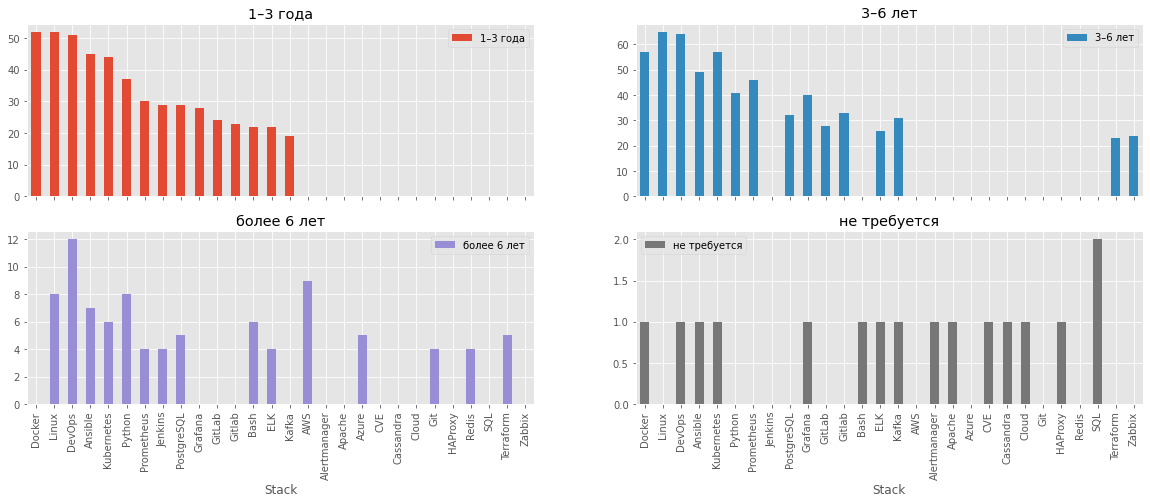

In [5]:
df[['Exp','Stack']].explode('Stack').groupby('Exp')['Stack'].value_counts()\
    .groupby(level=0).nlargest(15).reset_index(0,drop=True).unstack(0).sort_values(by='1–3 года',ascending=False).plot.bar(subplots=True,layout=(2,2))

<AxesSubplot:title={'center':'Salary'}, xlabel='Exp'>

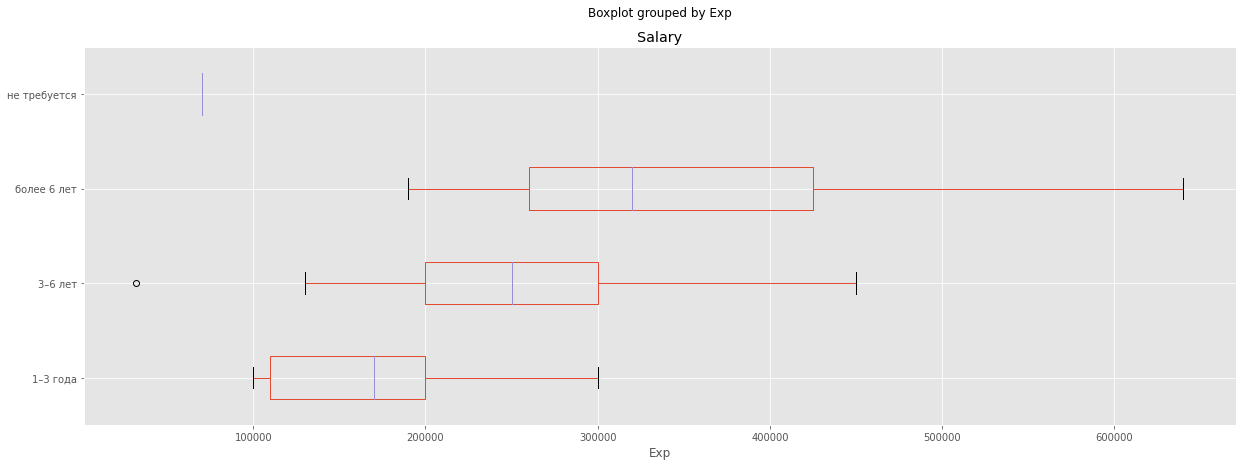

In [6]:
df.boxplot('Salary',by='Exp',vert=False)

In [16]:
df['is_russia']=df['Description'].apply(lambda x: len(re.findall('[А-я]+',x)) / (len(re.findall('[A-z]+',x)))).clip(0,1)

In [17]:
stack_salary_impact = df.query('is_russia==1')[['Stack','Salary']].explode('Stack').groupby('Stack')['Salary'].agg(['mean','count']).where(lambda x: x['count']>5).dropna()['mean'].div(df.query('is_russia==1')['Salary'].median()).sub(1).sort_values(ascending=False)

<AxesSubplot:title={'center':'Impact of stack with median wage 200k'}, ylabel='Stack'>

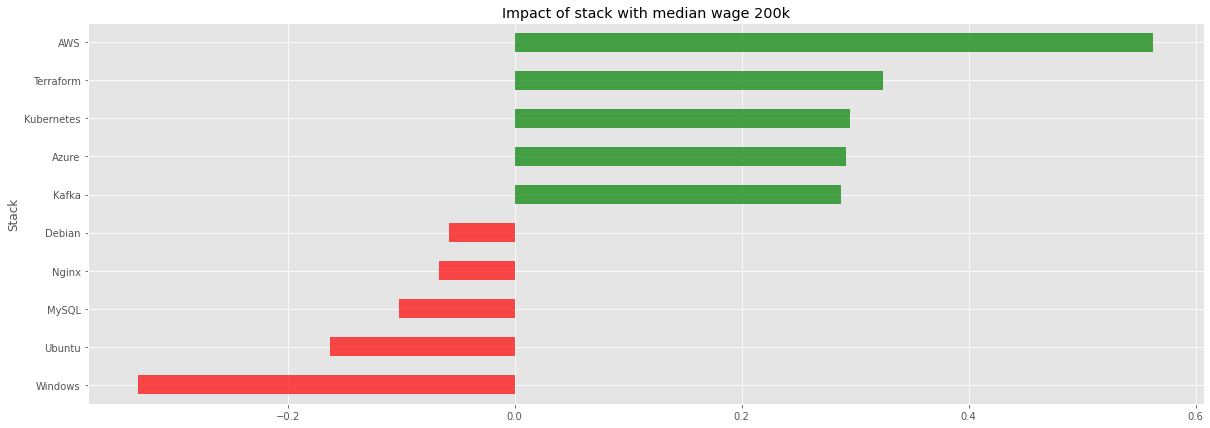

In [18]:
stack_salary_impact.head(5).append(stack_salary_impact.tail(5)).iloc[::-1].plot.barh(color=['r']*5+['g']*5,title=f'Impact of stack with median wage {df.query("is_russia!=0").Salary.median()/1000:.0f}k',alpha=0.7)

In [19]:
df[df.Name.str.contains('J|jun')]

,Name,Company,Salary,Exp,Type,Description,Tags,url,date,Query,Stack,is_russia
29,"DevOps инженер trainee, junior, middle, lead",Альфа-Банк,NaN,1–3 года,"Полная занятость, полный день",Ищем Devops инженера Junior и Middle уровней. ...,"[Python, Postgre, SQL, Bash, Linux, Mongo, DB]",https://hh.ru/vacancy/54759005,2022-04-22,,"[Apache, Junior, Middle, Cassandra, Python, Ve...",1.0
154,Junior DevOps / DevSecOps Engineer (в компанию...,Нек. орг. Фонд Сколково,NaN,1–3 года,"Полная занятость, полный день",Компания с 2011 года предоставляет услуги по з...,"[Linux, Bash, Git]",https://hh.ru/vacancy/54827104,2022-04-22,,"[DevOps, DevSecOps, Linux, JavaScript, Net, Wi...",1.0
161,Junior DevOps,ООО Управляющая компания Мой Гектар,NaN,1–3 года,"Полная занятость, удаленная работа",Видео о нас: https://youtu.be/UAOje6ycew4 В 20...,"[Git, Docker, My, SQL, Linux, Gitlabci, Kubern...",https://hh.ru/vacancy/51364421,2022-04-22,,"[PostgreSQL, Docker, Chef, Git, AWS, Terraform...",1.0
199,Инженер по внедрению\Junior Devops,Бюджетные и Финансовые Технологии,NaN,1–3 года,"Полная занятость, полный день",БФТ-Холдинг (входит в группу компаний «Ростеле...,"[Linux, Postgre, SQL]",https://hh.ru/vacancy/54928287,2022-04-22,,"[JOgrLOZ, Tadviser, FAIpQLSdNWBSIw, WPAnDdzNw,...",1.0


In [20]:
top_30_stack = df['Stack'].explode().value_counts().iloc[:30].index

In [21]:
data = df[['Salary','Description','Exp']].dropna()

In [22]:
for i in top_30_stack:
    data[f'has_{i}'] = data['Description'].str.contains(i)

In [23]:
data['Exp'] = data['Exp'].str.findall('\d').apply(lambda x: min(x) if x!=[] else 0).astype(int)

<AxesSubplot:>

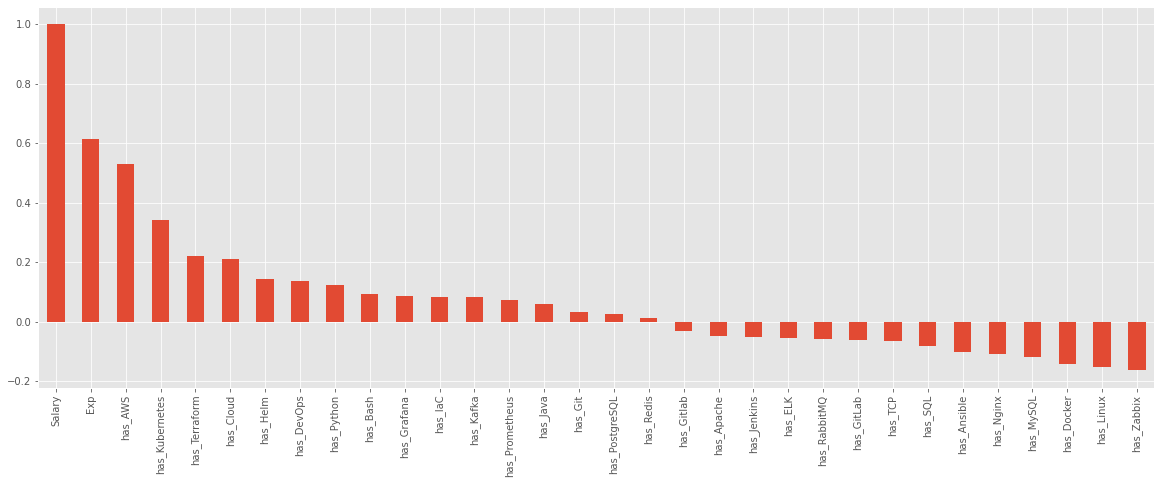

In [24]:
data.corr()['Salary'].sort_values(ascending=False).plot.bar()